importing libraries

In [53]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

importing data

In [55]:
train='../input/dog-breed-identification/train'
test='../input/dog-breed-identification/test'
label=pd.read_csv('../input/dog-breed-identification/labels.csv')
sample=pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [56]:
label.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [57]:
def append_jpg(id):
    return id+'.jpg'

In [73]:
label['id']=label['id'].apply(append_jpg)
sample['id']=sample['id'].apply(append_jpg)

selecting breeds

In [59]:
breed_list=['beagle','chihuahua','doberman','french_bulldog','golden_retriever','malamute','pug','saint_bernard','scottish_deerhound','tibetan_mastiff']
for i,row in enumerate(label['breed']):
    if row not in breed_list:
        label=label.drop([i])
label.shape

(841, 2)

In [98]:
for col in sample:
    if col not in breed_list:
        sample=sample.drop([col],axis=1)
sample.shape        

(10357, 10)

In [60]:
datagen=ImageDataGenerator(validation_split=0.25,rescale=1/255)

splitting data into train and validation 

In [61]:
train_generator=datagen.flow_from_dataframe(label,
                                            train,
                                            x_col='id',
                                            y_col='breed',
                                            target_size=(224,224),
                                            class_mode='categorical',
                                            subset='training',
                                            seed=0)
validation_generator=datagen.flow_from_dataframe(label,
                                           train,
                                           x_col='id',
                                           y_col='breed',
                                           target_size=(224,224),
                                           class_mode='categorical',
                                           subset='validation',
                                           seed=0)

Found 631 validated image filenames belonging to 10 classes.
Found 210 validated image filenames belonging to 10 classes.


In [74]:
test_datagen=ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow_from_dataframe(sample,
                                               test,
                                               x_col='id',
                                               y_col=None,
                                               target_size=(224,224),
                                               class_mode=None,
                                               seed=0)

Found 10357 validated image filenames.


using resnet50 model

In [62]:
res_model = tf.keras.applications.ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
res_model.trainable = False

In [138]:
dog_breeds = list(train_generator.class_indices.keys())
dog_breeds

['beagle',
 'chihuahua',
 'doberman',
 'french_bulldog',
 'golden_retriever',
 'malamute',
 'pug',
 'saint_bernard',
 'scottish_deerhound',
 'tibetan_mastiff']

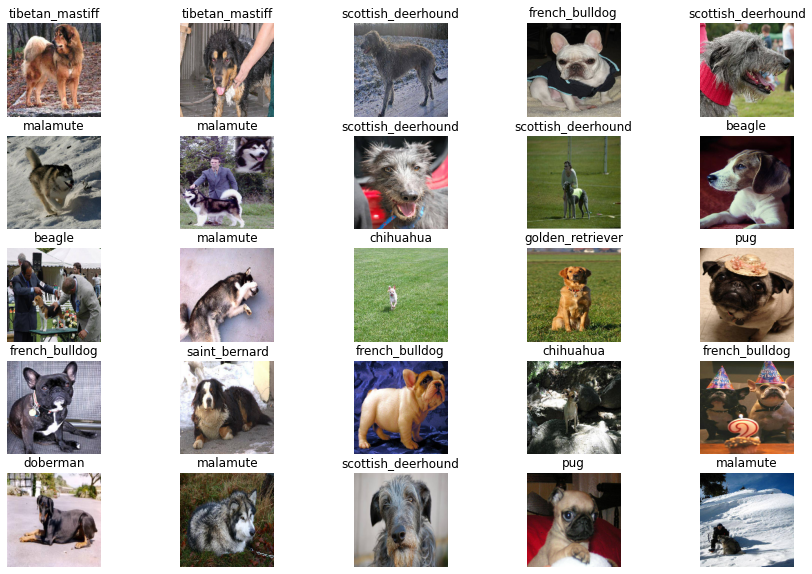

In [64]:
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(dog_breeds[np.argmax(labels[i])])
        plt.axis('off')
x,y = next(train_generator)
plot_images(x,y)

In [65]:
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout,Conv2D
from tensorflow.keras.models import Sequential

transfer learning 
dense layers are added to resnet50 

In [66]:
model=Sequential([
    res_model,
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(512,activation='relu'),
    Dropout(0.5),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dense(10,activation='softmax')
    
])

In [120]:
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.SGD(lr=0.001),metrics=['accuracy'])

In [121]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

In [122]:
my_calls=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
         tf.keras.callbacks.ModelCheckpoint('Model.h5',verbose=2,save_best_only=True)]

In [123]:
hist = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=50,
                              validation_data=validation_generator,validation_steps=validation_steps,callbacks=my_calls)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
19/19 [==============================] - 10s 340ms/step - loss: 0.7462 - accuracy: 0.8318 - val_loss: 0.3803 - val_accuracy: 0.9271

Epoch 00001: val_loss improved from inf to 0.38030, saving model to Model.h5
Epoch 2/50
19/19 [==============================] - 4s 231ms/step - loss: 0.5721 - accuracy: 0.8580 - val_loss: 0.3312 - val_accuracy: 0.9271

Epoch 00002: val_loss improved from 0.38030 to 0.33115, saving model to Model.h5
Epoch 3/50
19/19 [==============================] - 5s 245ms/step - loss: 0.6439 - accuracy: 0.8306 - val_loss: 0.4962 - val_accuracy: 0.8906

Epoch 00003: val_loss did not improve from 0.33115


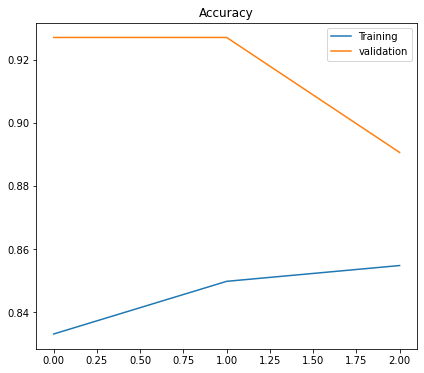

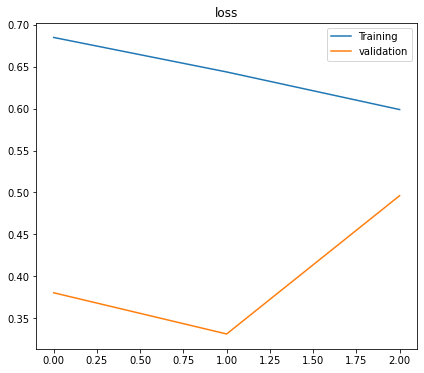

In [124]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label='Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label='validation')
plt.title('Accuracy')
plt.legend()

plt.figure(figsize=(15,6))
plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label='Training')
plt.plot(hist.epoch,hist.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

predicting test data

In [125]:
pred=model.predict(test_generator)

In [126]:
pred

array([[9.9573554e-05, 3.9356183e-03, 2.0653969e-01, ..., 6.8364796e-05,
        5.8067894e-01, 1.7024212e-01],
       [6.8400755e-06, 6.6391763e-04, 5.4754568e-03, ..., 1.9970719e-05,
        9.9120772e-01, 6.9556845e-05],
       [3.7536724e-05, 4.4987359e-05, 7.1522576e-05, ..., 1.3656066e-03,
        1.1882039e-02, 9.8073262e-01],
       ...,
       [4.0586321e-03, 1.1839108e-01, 7.1856733e-03, ..., 1.3349936e-03,
        6.3411355e-01, 2.0862888e-03],
       [4.8903991e-07, 5.4324113e-07, 9.7101780e-05, ..., 3.8599782e-07,
        9.9986267e-01, 9.5868735e-08],
       [2.0037717e-03, 1.2772228e-02, 8.1771081e-03, ..., 7.7492950e-06,
        1.0406745e-02, 1.0849154e-04]], dtype=float32)

In [127]:
submission=pd.read_csv('../input/dog-breed-identification/sample_submission.csv')
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [128]:
sample.insert(0,'id',value=submission['id'])

ValueError: cannot insert id, already exists

In [129]:
sample.iloc[:,1:]=pred

In [130]:
sample.head()

,id,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
0,000621fb3cbb32d8935728e48679680e,0.000100,0.003936,0.206540,0.016304,0.010327,0.010455,0.001349,0.000068,0.580679,0.170242
1,00102ee9d8eb90812350685311fe5890,0.000007,0.000664,0.005475,0.000316,0.000147,0.001204,0.000889,0.000020,0.991208,0.000070
2,0012a730dfa437f5f3613fb75efcd4ce,0.000038,0.000045,0.000072,0.000293,0.005124,0.000137,0.000312,0.001366,0.011882,0.980733
3,001510bc8570bbeee98c8d80c8a95ec1,0.000232,0.000100,0.008361,0.001072,0.003081,0.010525,0.000145,0.000284,0.509242,0.466957
4,001a5f3114548acdefa3d4da05474c2e,0.002716,0.007514,0.008959,0.008086,0.013509,0.077558,0.009199,0.013925,0.037144,0.821390


evaluation on validation data

In [134]:
loss,accuracy=model.evaluate(validation_generator,batch_size=32)
print('loss: ',loss)
print('accuracy: ',accuracy)


7/7 [==============================] - 1s 148ms/step - loss: 0.4616 - accuracy: 0.8952
loss:  0.461555540561676
accuracy:  0.8952381014823914


In [135]:
model.save('dogclassification.h5')

In [ ]:
sample.to_csv('submission.csv')